# Stokes Sinker

Demonstration example for setting up particle swarms with different material properties. This system consists of a dense, high viscosity sphere falling through a background lower density and viscosity fluid. 

In [1]:
import UWGeodynamics as GEO
import glucifer

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
velocity = 1.0 * u.centimeter / u.hour
model_length = 2. * u.meter
model_height = 1. * u.meter
refViscosity = 1e6 * u.pascal * u.second
bodyforce = 200 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_height
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [4]:
Model = GEO.Model(elementRes=(64, 64), 
                  minCoord=(-1. * u.meter, -50. * u.centimeter), 
                  maxCoord=(1. * u.meter, 50. * u.centimeter))

In [5]:
lightMaterial = Model.add_material(name="Light", shape=GEO.shapes.Layer2D(top=Model.top, bottom=Model.bottom))
heavyMaterial = Model.add_material(name="Heavy", shape=GEO.shapes.Disk(center=(0.,30.*u.centimetre), radius=10. * u.centimetre))

In [6]:
lightMaterial.density = 10 * u.kilogram / u.metre**3
heavyMaterial.density = 500 * u.kilogram / u.metre**3

lightMaterial.viscosity = GEO.ConstantViscosity(1e6 * u.pascal * u.second)
heavyMaterial.viscosity = GEO.ConstantViscosity(1e6 * u.pascal * u.second)

In [7]:
Model.set_velocityBCs(left=[0, None], right=[0,None], top=[None, 0.], bottom=[None, 0])


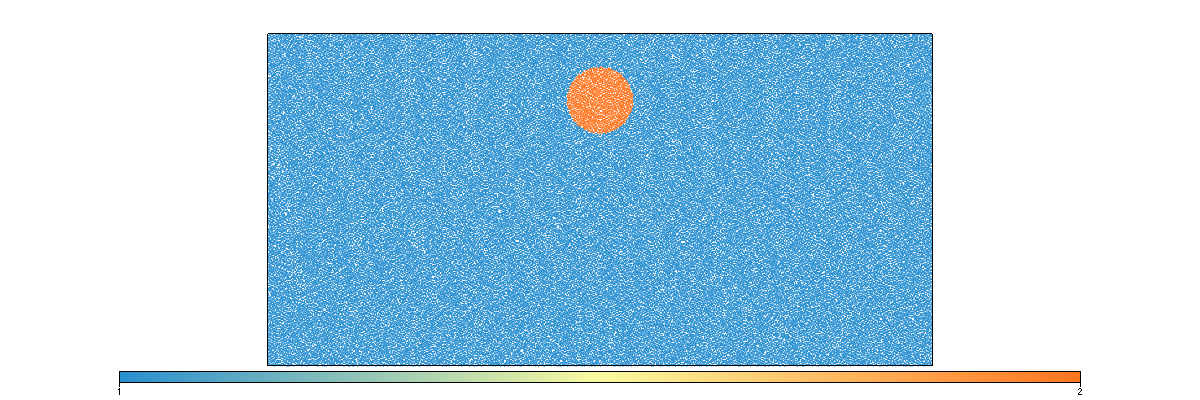

In [8]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

Analysis tools
-----

In [9]:
import underworld as uw
import underworld.function as fn

**RMS velocity**

Set up integrals used to calculate the RMS velocity.

In [10]:
vdotv = fn.math.dot(Model.velocityField, Model.velocityField)
v2sum_integral  = uw.utils.Integral(mesh=Model.mesh, fn=vdotv )
volume_integral = uw.utils.Integral(mesh=Model.mesh, fn=1. )

**Define minimum y coordinate function**

Define a function that finds the minimum y coordinate value for the sinker particles. This function uses the in-built min/max function from ``underworld`` to obtain the minimum and maximum values of the function across all processors. The minimum values from each processor are gathered by the global min function which is then returned.

In [11]:
x0, y0 = 0, 20. * u.centimetre
Model.add_passive_tracers(name="tip", vertices=[x0, y0])

In [12]:
tSinker = [0.]
ypos = Model.tip_tracers.swarm.particleCoordinates.data[:,1][0]
ypos = GEO.Dimensionalize(ypos, u.centimetre)
ypos = ypos.magnitude
ySinker = [ypos]

def post_solve_hook():
    global tSinker
    global ySinker
    
    time = Model.time.to(u.hour).magnitude
    ypos = Model.tip_tracers.swarm.particleCoordinates.data[:,1][0]
    ypos = GEO.Dimensionalize(ypos, u.centimetre)
    ypos = ypos.magnitude
    
    tSinker.append(time)
    ySinker.append(ypos)

In [13]:
Model.postSolveHook = post_solve_hook

In [14]:
Model.init_model()

In [15]:
!rm -rf outputs/
Model.run_for(1.0 * u.hours)

Running with UWGeodynamics version 0.9.8b-dev-29e4c3b(development)
Step:1 Model Time:  0.13061856719052997 hour dt: 0.13061856719052997 hour (2018-11-27 08:50:26)
Step:2 Model Time:  0.25929877957914066 hour dt: 0.12868021238861072 hour (2018-11-27 08:50:28)
Step:3 Model Time:  0.3856573510896559 hour dt: 0.1263585715105152 hour (2018-11-27 08:50:29)
Step:4 Model Time:  0.5111900741291426 hour dt: 0.12553272303948676 hour (2018-11-27 08:50:31)
Step:5 Model Time:  0.6346641507696938 hour dt: 0.12347407664055118 hour (2018-11-27 08:50:32)
Step:6 Model Time:  0.7565584633280915 hour dt: 0.12189431255839764 hour (2018-11-27 08:50:33)
Step:7 Model Time:  0.8766259602450174 hour dt: 0.12006749691692589 hour (2018-11-27 08:50:34)
Step:8 Model Time:  0.9952270173627549 hour dt: 0.11860105711773757 hour (2018-11-27 08:50:35)
Step:9 Model Time:  1.0 hour dt: 0.00477298263724512 hour (2018-11-27 08:50:36)


1


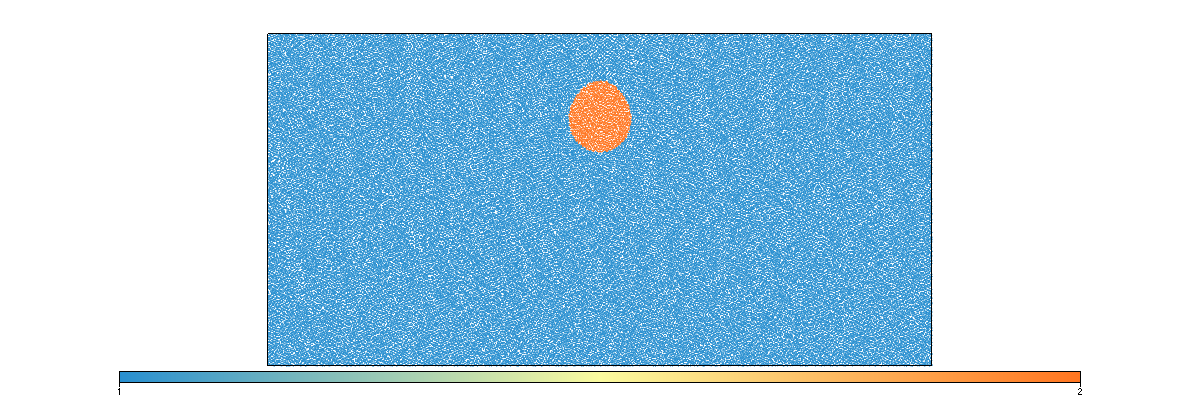

In [16]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()


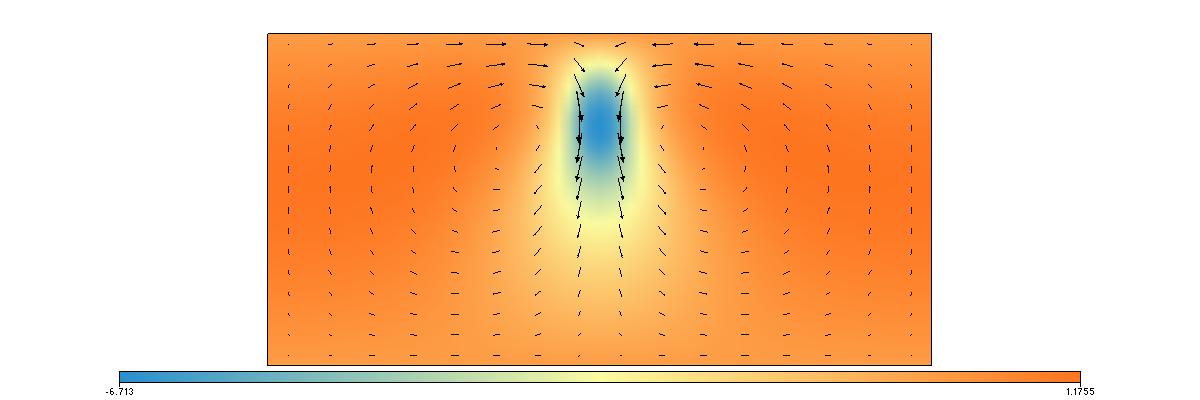

In [17]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, Model.velocityField[1], fn_size=2.0)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()


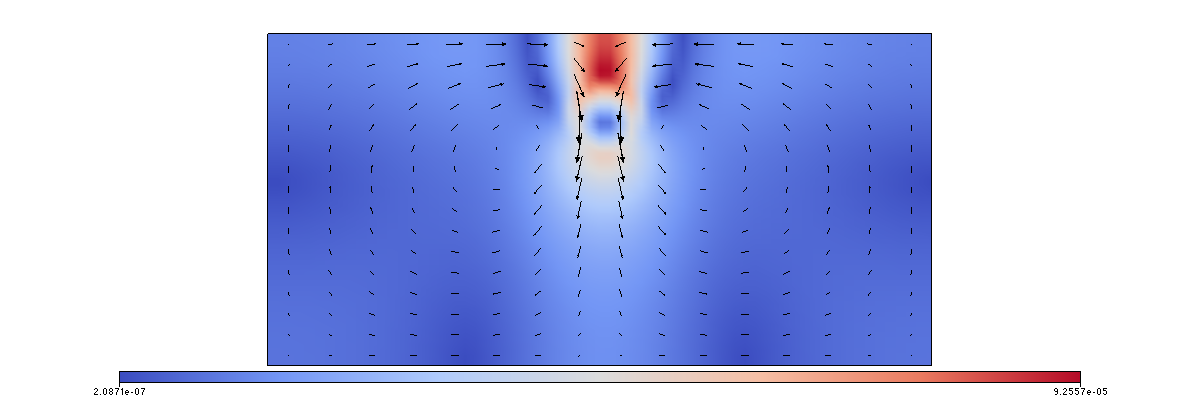

In [18]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, GEO.Dimensionalize(Model.strainRateField, 1.0 / u.second), colours="coolwarm")
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()

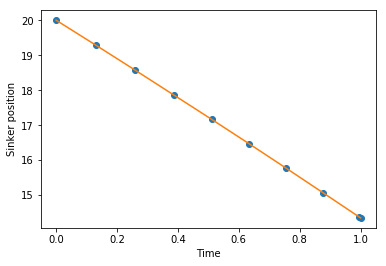

In [21]:
if(uw.rank()==0):
    import matplotlib.pyplot as plt
    plt.plot(tSinker, ySinker, "o") 
    plt.plot(tSinker, ySinker) 
    plt.xlabel('Time')
    plt.ylabel('Sinker position')
    plt.show()